## ALGORITMO DBSCAN

## Importacion de librerias


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
%matplotlib inline

### Importacion de archivo


In [ ]:
from google.colab import drive #importamos
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leemos el archivo csv
credit_card_fraud = pd.read_csv('/content/drive/My Drive/Curso Ingenias/fraud_test.csv', delimiter=',',index_col=0)

Nombres de las columnas del dataset:


In [ ]:
credit_card_fraud.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
# Se observa cuantas filas y columnas tiene
print("\nEl dataframe tiene {} filas y {} columnas.".format(credit_card_fraud.shape[0], credit_card_fraud.shape[1]))


El dataframe tiene 555719 filas y 22 columnas.


Modifico columnas y renombro valores de la columna categoria

In [ ]:
# Para facilitar nuestro dataset, se renombran las columnnas de ingles a español.
# Diccionario de mapeo de nombres en inglés a español
columnas_renombradas = {
    'trans_date_trans_time': 'fecha_transaccion',
    'cc_num': 'num_tarjeta',
    'merchant': 'comerciante',
    'category': 'categoria',
    'amt': 'monto',
    'first': 'nombre',
    'last': 'apellido',
    'gender': 'genero',
    'street': 'calle',
    'city': 'ciudad',
    'state': 'estado',
    'zip': 'codigo_postal',
    'lat': 'latitud',
    'long': 'longitud',
    'city_pop': 'poblacion_ciudad',
    'job': 'trabajo',
    'dob': 'fecha_nacimiento',
    'trans_num': 'num_transaccion',
    'unix_time': 'tiempo_unix',
    'merch_lat': 'latitud_comerciante',
    'merch_long': 'longitud_comerciante',
    'is_fraud': 'es_fraude'
}

credit_card_fraud.rename(columns=columnas_renombradas, inplace=True)

In [ ]:
#renombramos la columna de inglés a español
categorias_renombradas = {
    'gas_transport': 'gasolina_transporte',
    'grocery_pos': 'supermercado',
    'home': 'hogar',
    'shopping_pos': 'compras',
    'kids_pets': 'niños_mascotas',
    'shopping_net': 'compras_en_linea',
    'entertainment': 'entretenimiento',
    'personal_care': 'cuidado_personal',
    'food_dining': 'comida',
    'health_fitness': 'salud_ejercicio',
    'misc_pos': 'varios',
    'misc_net': 'varios_en_linea',
    'grocery_net': 'supermercado_en_linea',
    'travel': 'viajes'
}

credit_card_fraud['categoria'] = credit_card_fraud['categoria'].replace(categorias_renombradas)

Se crean columnas nuevas para tener la fecha y hora separadas.

In [ ]:
credit_card_fraud['trans_fecha'] = pd.to_datetime(credit_card_fraud['fecha_transaccion']).dt.date
credit_card_fraud['trans_hora'] = pd.to_datetime(credit_card_fraud['fecha_transaccion']).dt.hour

C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\4269891916.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  credit_card_fraud['trans_fecha'] = pd.to_datetime(credit_card_fraud['fecha_transaccion']).dt.date
C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\4269891916.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  credit_card_fraud['trans_hora'] = pd.to_datetime(credit_card_fraud['fecha_transaccion']).dt.hour


In [ ]:
credit_card_fraud.head(3)

,fecha_transaccion,num_tarjeta,comerciante,categoria,monto,nombre,apellido,genero,calle,ciudad,...,poblacion_ciudad,trabajo,fecha_nacimiento,num_transaccion,tiempo_unix,latitud_comerciante,longitud_comerciante,es_fraude,trans_fecha,trans_hora
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,cuidado_personal,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020-06-21,12
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,cuidado_personal,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2020-06-21,12
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",salud_ejercicio,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,2020-06-21,12


# Filtrar dataset

Como el dataset es muy grande y no necesito las 24 columnas lo redujo

In [ ]:
#fraude , lat ,long , comerciante, monto , poblacion de ciudad , lat y long
columnas_deseadas = ['es_fraude','trans_hora', 'latitud','longitud', 'categoria', 'monto', 'poblacion_ciudad','estado','latitud_comerciante','longitud_comerciante']

# Filtrar el dataset para incluir solo las columnas deseadas
df_1 = credit_card_fraud[columnas_deseadas]

En el análisis inicial de los datos, se identificaron cinco estados con la mayor cantidad de fraudes. Estos estados son:
*   NY : Nueva York
*   PA : Pennsylvania
*   TX: Texas
*   CA: CALIFORNIA
*   IL: Illinois

Además, se observaron cinco categorías destacadas en relación con el fraude:
* gasolina_transporte
* supermercado
* hogar
* compras
* niños_mascotas

Por lo tanto , se filtra el dataset con los datos mencionados


In [ ]:
#top 5 categorias y estados
estados=['NY','PA','TX','CA','IL']
categoria=['gasolina_transporte','supermercado','hogar','compras','niños_mascotas']

In [ ]:
df_2=df_1[df_1['estado'].isin(estados)]  # solo 5 estados
df_3=df_2[df_1['categoria'].isin(categoria)] # solo 5 estados y 5 categorias

C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\3718380885.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_3=df_2[df_1['categoria'].isin(categoria)] # solo 5 estados y 5 categorias


Como dbscan solo analiza datos numericos cambie las categoricas a numericas

In [ ]:
categorias_renombradas = {
    'gasolina_transporte':1,
    'supermercado':2,
    'hogar':3,
    'compras':4,
    'niños_mascotas':5,
}

estados_renombradas = {
    'NY':1,
    'PA':2,
    'TX':3,
    'CA':4,
    'IL':5,
}

df_3['categoria'] = df_3['categoria'].replace(categorias_renombradas)
df_3['estado'] = df_3['estado'].replace(estados_renombradas)

C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\1912067067.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['categoria'] = df_3['categoria'].replace(categorias_renombradas)
C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\1912067067.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['estado'] = df_3['estado'].replace(estados_renombradas)


In [ ]:
df_3['estado'].value_counts() # verifico

estado
3    18876
1    16925
2    15907
4    11378
5     8799
Name: count, dtype: int64

## Distancia K

Para encontrar el valor adecuado de 𝜖 (distancia máxima) para el algoritmo DBSCAN, puedes utilizar el método de la gráfica del codo (elbow method) basado en la distancia al 𝑘-ésimo vecino más cercano. Aquí te explico cómo hacerlo

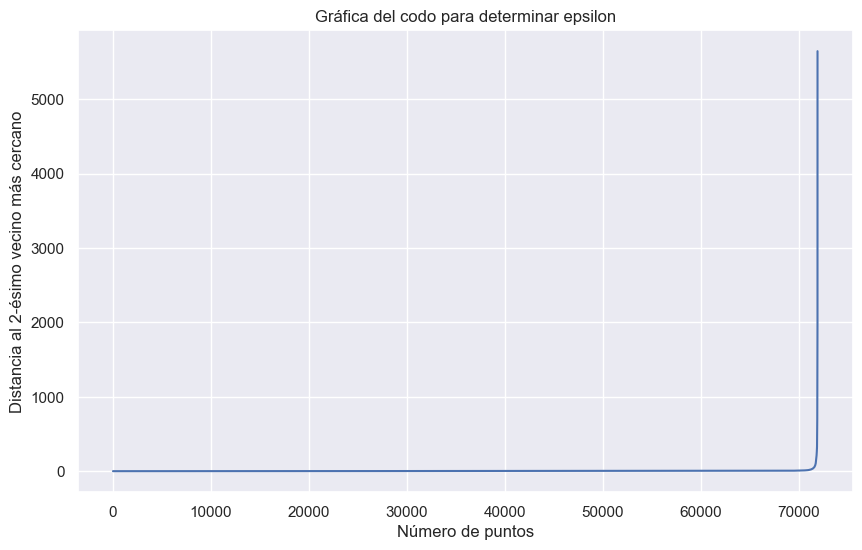

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 2

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_3)
distances, indices = neighbors_fit.kneighbors(df_3)

# Ordenar las distancias
distances = np.sort(distances[:, k-1], axis=0)

# Graficar
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.xlabel('Número de puntos')
plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano')
plt.title('Gráfica del codo para determinar epsilon')
plt.show()

Con el metodo , se encontro que el eps seria 0.1 a 0.

## DBSCAN

#### **PRIMER MODELO**



In [ ]:
#modelo con df_3
dbscan1 = DBSCAN(eps=0.5, min_samples=4)
labels = dbscan1.fit_predict(df_3)
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
num_noise = np.sum(labels == -1)

print(f"Clusters encontrados: {num_clusters}")
print(f"Ruido (outliers): {num_noise}")
df_3['cluster'] = labels  # agrego los numero de cluster enconcontrados

Clusters encontrados: 1
Ruido (outliers): 71881


C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\334228374.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['cluster'] = labels  # agrego los numero de cluster enconcontrados


- eps=0.5: Define el radio máximo en el que se buscarán vecinos alrededor de cada punto. Este valor determina la "densidad" requerida para que un grupo de puntos sea considerado un clúster.
- min_samples=4: Especifica el número mínimo de puntos que deben estar dentro del radio eps para que un punto sea considerado como un núcleo de clúster. Esto asegura que solo se formen clústeres en áreas con una concentración suficiente de puntos.

Clusters encontrados: 1
El algoritmo identificó 1 clústeres distintos en los datos.
Ruido (outliers): 71881 . Se encontro ruido por lo cual puede que haya datos anomalos

#### **Segundo Modelo**

In [ ]:
#Modelo 2
dbscan1 = DBSCAN(eps=0.1, min_samples=6)
labels1 = dbscan1.fit_predict(df_3)
unique_labels = np.unique(labels1)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
num_noise = np.sum(labels == -1)

print(f"Clusters encontrados: {num_clusters}")
print(f"Ruido (outliers): {num_noise}")

df_3['cluster2'] = labels

Clusters encontrados: 0
Ruido (outliers): 71881


C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\767705227.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['cluster2'] = labels


A diferencia del primero ,en este modelo solo hay ruido en este hay solo ruido .

#### **Tercer Modelo**

Se realiza dataset especificos para analizar para encontrar más grupos.

In [ ]:
X=df_3[['monto','trans_hora', 'poblacion_ciudad','categoria','estado']]

In [ ]:
dbscan1 = DBSCAN(eps=0.7, min_samples=6)
labels1 = dbscan1.fit_predict(X)
unique_labels = np.unique(labels1)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
num_noise = np.sum(labels == -1)

print(f"Clusters encontrados: {num_clusters}")
print(f"Ruido (outliers): {num_noise}")

X['Cluster'] = labels

Clusters encontrados: 13
Ruido (outliers): 71881


C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\211880601.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = labels


El análisis utilizando el algoritmo DBSCAN con 𝜖=0.7 y min_samples = 6 ha producido los siguientes resultados:

Clusters encontrados: Se han identificado 13 clusters distintos dentro de los datos. Estos clusters representan grupos de puntos que están cercanos entre sí según la métrica de distancia definida por el valor de 𝜖

Ruido (outliers): Un total de 71,881 puntos fueron clasificados como ruido o outliers. Estos puntos no pudieron ser agrupados en ninguno de los clusters definidos, lo que sugiere que no tienen suficientes vecinos dentro del rango de distancia especificado para ser considerados parte de un cluster o  indica que una gran parte de los datos no se ajusta bien a los clusters formados.


#### Cuarto modelo

In [ ]:
dbscan1 = DBSCAN(eps=0.4, min_samples=6)
labels2 = dbscan1.fit_predict(X)
unique_labels = np.unique(labels2)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
num_noise = np.sum(labels == -1)

print(f"Clusters encontrados: {num_clusters}")
print(f"Ruido (outliers): {num_noise}")

X['cluster2'] = labels2

Clusters encontrados: 2
Ruido (outliers): 71881


C:\Users\mikpz\AppData\Local\Temp\ipykernel_6228\2126349132.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster2'] = labels2  # agrego los numero de cluster enconcontrado


El análisis utilizando el algoritmo DBSCAN con 𝜖=0.4 y min_samples = 6 ha producido los siguientes resultados:

Clusters encontrados: Se han identificado 2 clusters distintos dentro de los datos. Estos clusters representan grupos de puntos que están cercanos entre sí según la métrica de distancia definida por el valor de 𝜖

Ruido (outliers): Un total de 71,881 puntos fueron clasificados como ruido o outliers. Estos puntos no pudieron ser agrupados en ninguno de los clusters definidos, lo que sugiere que no tienen suficientes vecinos dentro del rango de distancia especificado para ser considerados parte de un cluster o  indica que una gran parte de los datos no se ajusta bien a los clusters formados.


## Graficos

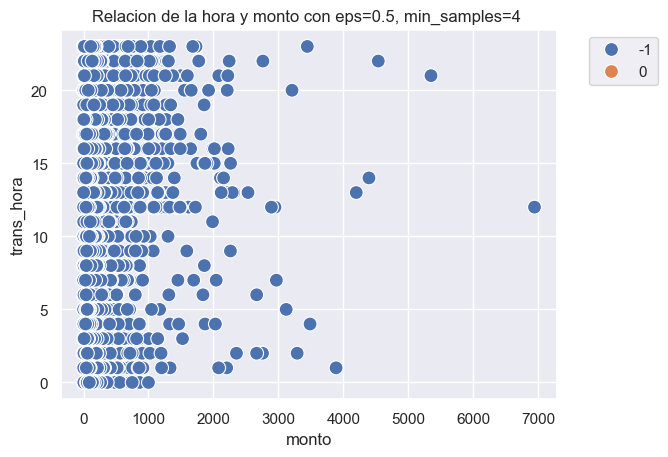

In [ ]:
sns.scatterplot(data=df_3, x='monto', y='trans_hora', hue='cluster', palette='deep', s=100)
plt.title('Relacion de la hora y monto con eps=0.5, min_samples=4 ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- Eje X (Monto): Representa el valor monetario de las transacciones.
- Eje Y (trans_hora): Indica la hora en la que se realizaron las transacciones.

Se observa el unico grupos identificados en la leyenda ya que solo se muestra los outliders.
No obstante, si estuvieras buscando detectar outliers específicos, podrías considerar ajustar eps a un valor más bajo o aumentar min_samples.

#### **POBLACION VS MONTO**

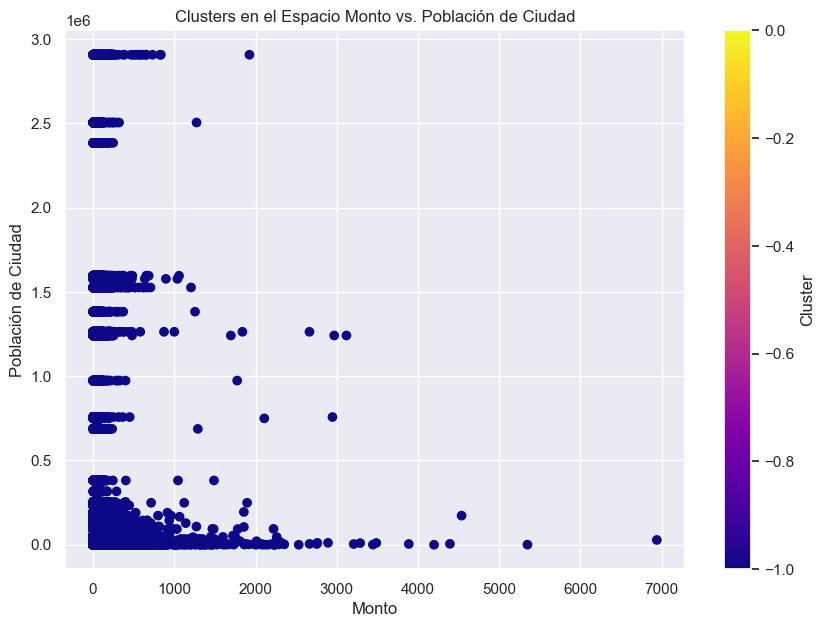

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(10, 7))
plt.scatter(X['monto'], X['poblacion_ciudad'], c=labels, cmap='plasma')
plt.xlabel('Monto')
plt.ylabel('Población de Ciudad')
plt.title('Clusters en el Monto vs. Población de Ciudad')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

- Eje X (Monto): Representa el valor monetario de las transacciones.
- Eje Y (Población de Ciudad): Indica la población de la ciudad en la que se realizaron las transacciones.
- La coloración es manejada por la paleta plasma, que varía desde tonos más oscuros a más claros dependiendo del clúster asignado a cada punto.

En el grafico solo se observa los puntos outliers.

#### **HORA VS MONTO**

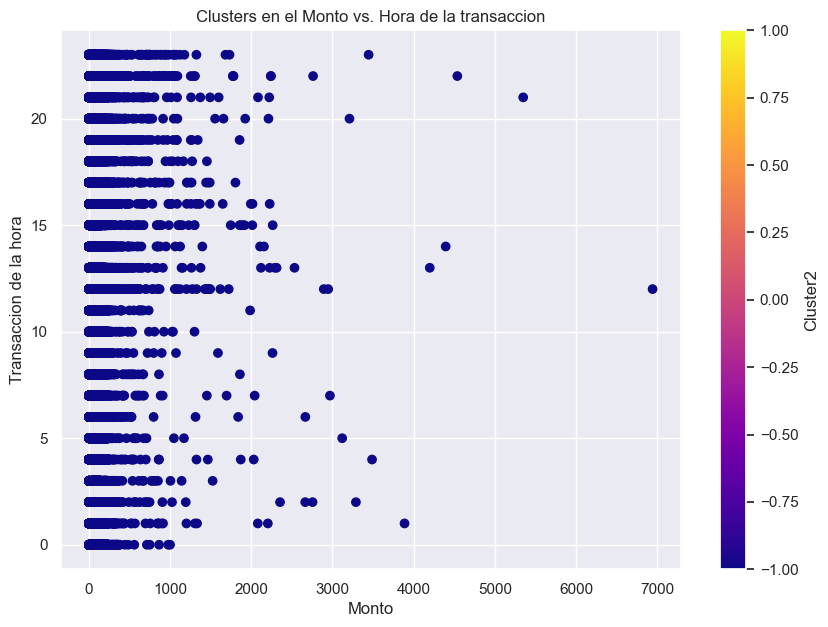

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(10, 7))
plt.scatter(X['monto'], X['trans_hora'], c=labels2, cmap='plasma')
plt.xlabel('Monto')
plt.ylabel('Transaccion de la hora')
plt.title('Clusters en el Monto vs. Hora de la transaccion')
plt.colorbar(label='Cluster2')
plt.grid(True)
plt.show()

- Eje X (Monto): Representa el valor monetario de las transacciones.
- Eje Y (transaccion de la hora): Indica la trasnsaccion que se realizo a tal hora en la que se realizaron las transacciones.
- La coloración es manejada por la paleta plasma, que varía desde tonos más oscuros a más claros dependiendo del clúster asignado a cada punto.

No se identifica los puntos como ruido, lo que indica que, bajo los parámetros seleccionados (eps=0.7, min_samples=6). No se observan los cluesters .

### Conclusion

A pesar de haber evaluado cuatro modelos diferentes, el análisis sugiere que el modelo DBSCAN podría no ser el más adecuado para este dataset. Sería recomendable realizar un análisis más profundo de los resultados de clustering, enfocándose en la evaluación de la cantidad y distribución de los outliers.

Además, se podrían aplicar técnicas de reducción de dimensionalidad como PCA (Análisis de Componentes Principales) o t-SNE para visualizar los clusters en 2D o 3D, lo que facilitaría la interpretación de los resultados y podría ofrecer una mejor comprensión de la estructura subyacente de los datos. Este enfoque permitiría mejorar la identificación y comprensión de los patrones en el dataset, optimizando así el proceso de clustering.

## Observaciones
Fue necesario seleccionar cuatro columnas específicas para ajustar el parámetro eps, ya que al utilizar el dataset completo, se observó una tendencia en la que prácticamente todos los puntos eran clasificados como outliers, sin formar clusters significativos. Además, no fue posible estandarizar los datos debido a un error de memoria (MemoryError), lo que limitó las opciones para mejorar el rendimiento del modelo.